# **Practical 2: Modelling Practical**
GD5302 - Health Data Science Practice

This jupyter notebook is part of the submission for the GD5302 - Health Data Science Practice, Practical 2: Modelling Practical.
Using functions from the python script hdsp_practical1_code.py it conducts machine learning analysis on the Breast Cancer Wisconsin Dataset. Results and methods are further discussed in the project report.

## **1. Imports**

In [1]:
# Importing libraries

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.pipeline
import sklearn.impute
import sklearn.compose
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from ucimlrepo import fetch_ucirepo 
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

# Display all columns when printing DataFrames
pd.set_option('display.max_columns', None)

In [2]:
# Import helper functions from python script
from code_hdsp_p2 import (
    split_data,
    plot_histograms,
    transform_features,
    scale_features,
    map_y,
    classify_skewness,
    winsorize,
    run_dimensionality_experiment,
    compute_metrics,
    run_random_search,
    create_pipeline,
    plot_results,
    decision_boundary,
    train_classifiers,
    get_pca_data,
    plot_cumulative_explained_variance,
    rank_results
)

In [3]:
# Importing Data Set
# code from: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

print(breast_cancer_wisconsin_diagnostic.metadata) 
print(breast_cancer_wisconsin_diagnostic.variables) 

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [4]:
df = X.copy()      # Make a copy of the features DataFrame
df['y'] = y   # Add the target as a new column

## **2. Exploration of Data**

In [5]:
# Create an exploration set, so i don't accidentally change the original data
df_explore = df.copy()
df_explore.head(10)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,M
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,M
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,M
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,M
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,M


In [6]:
# Initial Exploration
print("\nData shape:", df_explore.shape,'\n')
print(df_explore.info(),)
print("\nNumerical Summary:")
print(df_explore.describe())
print("\nCategorical Summary:")
print(df_explore.describe(include=['object']))


Data shape: (569, 31) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null

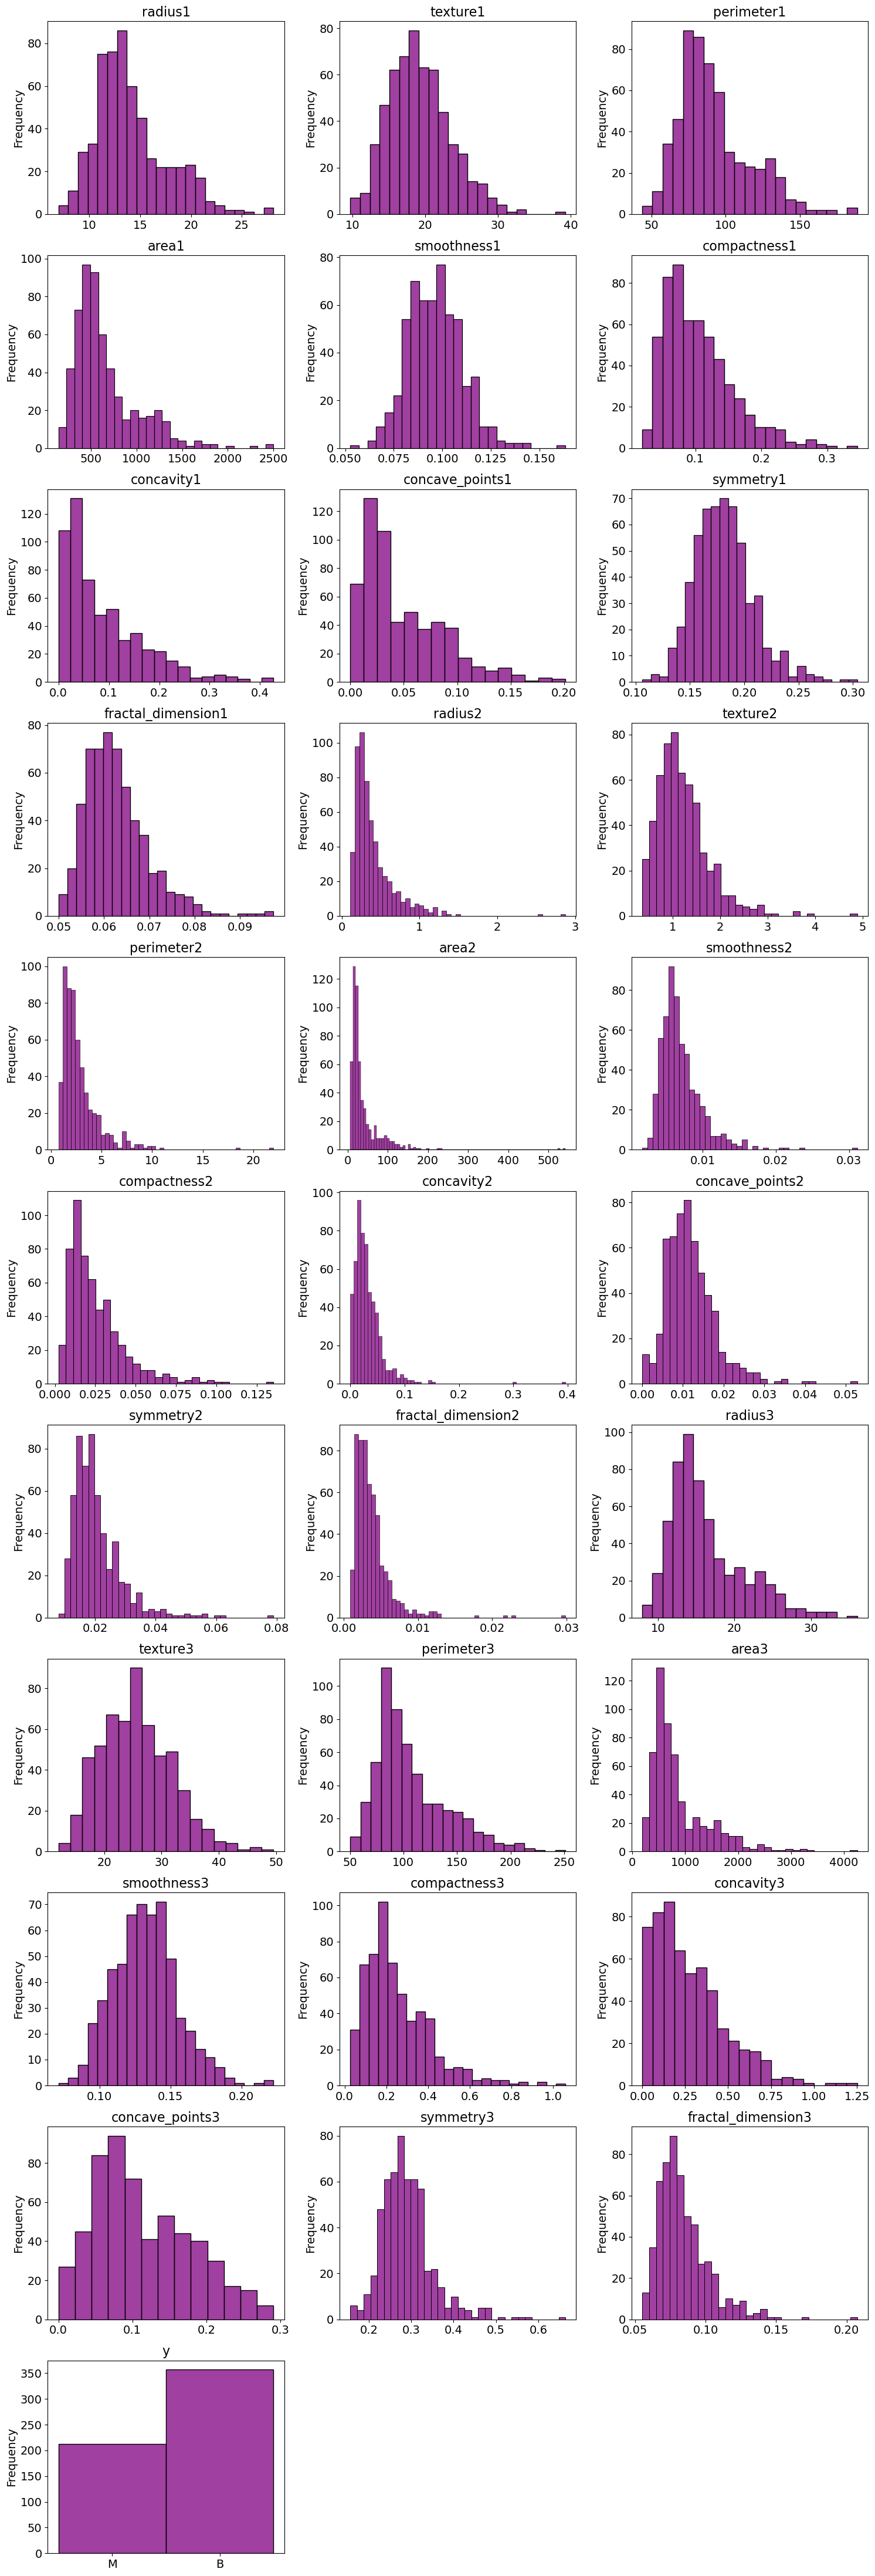

In [7]:
# Assessing distributions of features - especially heavy-tailed ones
plot_histograms(df_explore)

In [8]:
# In order to calculate linear correlations, first convert 'y' to a numerical feature.
map_y(df_explore)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1



Correlation with target 'y':
y                     1.000
concave_points3       0.794
perimeter3            0.783
concave_points1       0.777
radius3               0.776
perimeter1            0.743
area3                 0.734
radius1               0.730
area1                 0.709
concavity1            0.696
concavity3            0.660
compactness1          0.597
compactness3          0.591
radius2               0.567
perimeter2            0.556
area2                 0.548
texture3              0.457
smoothness3           0.421
symmetry3             0.416
texture1              0.415
concave_points2       0.408
smoothness1           0.359
symmetry1             0.330
fractal_dimension3    0.324
compactness2          0.293
concavity2            0.254
fractal_dimension2    0.078
symmetry2            -0.007
texture2             -0.008
fractal_dimension1   -0.013
smoothness2          -0.067
Name: y, dtype: float64


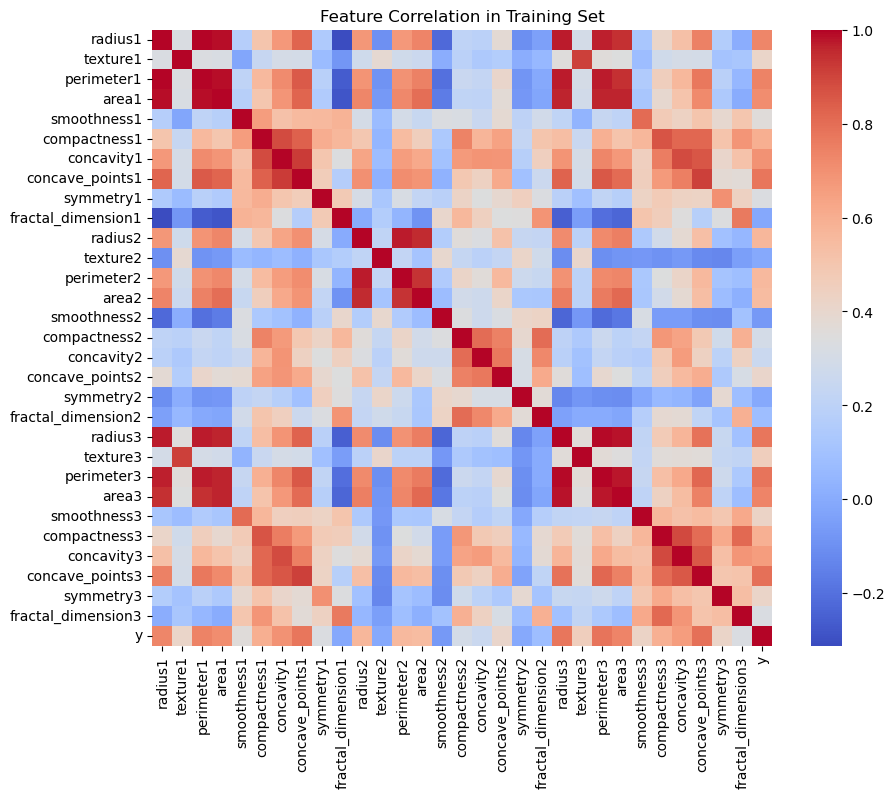

In [9]:
# Calculate linear correlations of features with 'y'
corr = df_explore.corr().round(3)
print("\nCorrelation with target 'y':")
print(corr['y'].sort_values(ascending=False))

# Visualising the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_explore.corr(), annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation in Training Set")
plt.show()

# **3. Data Preperation**

In [10]:
# Split the raw data before any cleaning/transformations
# Stratified on target y
train_set, validation_set, test_set = split_data(df, target='y', test_size=0.2, validation_size=0.2, random_state=5302) 
# The data set seems to be so small that random seed has quite large implications on performance

In [11]:
# Convert 'y' to a numerical feature
map_y(train_set)
map_y(validation_set)
map_y(test_set)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,y
375,16.17,16.07,106.30,788.5,0.09880,0.14380,0.06651,0.05397,0.1990,0.06572,0.1745,0.4890,1.349,14.91,0.004510,0.01812,0.01951,0.011960,0.01934,0.003696,16.97,19.14,113.10,861.5,0.1235,0.2550,0.2114,0.12510,0.3153,0.08960,0
131,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.094,48.31,0.006240,0.01484,0.02813,0.010930,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019,1
154,13.15,15.34,85.31,538.9,0.09384,0.08498,0.09293,0.03483,0.1822,0.06207,0.2710,0.7927,1.819,22.79,0.008584,0.02017,0.03047,0.009536,0.02769,0.003479,14.77,20.50,97.67,677.3,0.1478,0.2256,0.3009,0.09722,0.3849,0.08633,0
136,11.71,16.67,74.72,423.6,0.10510,0.06095,0.03592,0.02600,0.1339,0.05945,0.4489,2.5080,3.258,34.37,0.006578,0.01380,0.02662,0.013070,0.01359,0.003707,13.33,25.48,86.16,546.7,0.1271,0.1028,0.1046,0.06968,0.1712,0.07343,0
99,14.42,19.77,94.48,642.5,0.09752,0.11410,0.09388,0.05839,0.1879,0.06390,0.2895,1.8510,2.376,26.85,0.008005,0.02895,0.03321,0.014240,0.01462,0.004452,16.33,30.86,109.50,826.4,0.1431,0.3026,0.3194,0.15650,0.2718,0.09353,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,13.37,16.39,86.10,553.5,0.07115,0.07325,0.08092,0.02800,0.1422,0.05823,0.1639,1.1400,1.223,14.66,0.005919,0.03270,0.04957,0.010380,0.01208,0.004076,14.26,22.75,91.99,632.1,0.1025,0.2531,0.3308,0.08978,0.2048,0.07628,0
134,18.45,21.91,120.20,1075.0,0.09430,0.09709,0.11530,0.06847,0.1692,0.05727,0.5959,1.2020,3.766,68.35,0.006001,0.01422,0.02855,0.009148,0.01492,0.002205,22.52,31.39,145.60,1590.0,0.1465,0.2275,0.3965,0.13790,0.3109,0.07610,1
529,12.07,13.44,77.83,445.2,0.11000,0.09009,0.03781,0.02798,0.1657,0.06608,0.2513,0.5040,1.714,18.54,0.007327,0.01153,0.01798,0.007986,0.01962,0.002234,13.45,15.77,86.92,549.9,0.1521,0.1632,0.1622,0.07393,0.2781,0.08052,0
423,13.66,19.13,89.46,575.3,0.09057,0.11470,0.09657,0.04812,0.1848,0.06181,0.2244,0.8950,1.804,19.36,0.003980,0.02809,0.03669,0.012740,0.01581,0.003956,15.14,25.50,101.40,708.8,0.1147,0.3167,0.3660,0.14070,0.2744,0.08839,0


In [12]:
# Because I want to reduce dimensions using Principle Component Analysis (PCA), I need to remove outliers
# I'm using winzoring. When i transformed several features with log, they were still highly skewed afterwards.
train_winsorized, val_winsorized, test_winsorized = winsorize(train_set, validation_set, test_set, target='y', n_std=3)

In [13]:
# Classifying skewness of features and according level of transformation
no_trans, mild_trans, strong_trans = classify_skewness(train_winsorized)
print(f"\nNo Transformation Needed: {no_trans}")
print(f"Mild Transformation Needed: {mild_trans}")
print(f"Strong Transformation Needed: {strong_trans}")


No Transformation Needed: ['smoothness1', 'texture3', 'smoothness3', 'concave_points3']
Mild Transformation Needed: ['radius1', 'texture1', 'perimeter1', 'compactness1', 'symmetry1', 'concave_points2', 'symmetry3']
Strong Transformation Needed: ['area1', 'concavity1', 'concave_points1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'symmetry2', 'fractal_dimension2', 'radius3', 'perimeter3', 'area3', 'compactness3', 'concavity3', 'fractal_dimension3']


In [14]:
# Apply transformations based on skewness classification
train_transformed = transform_features(train_winsorized, mild_trans, method='sqrt')  # Square root for mild skew
train_transformed = transform_features(train_transformed, strong_trans, method='log')  # Log for strong skew

validation_transformed = transform_features(val_winsorized, mild_trans, method='sqrt')
validation_transformed = transform_features(validation_transformed, strong_trans, method='log')

test_transformed = transform_features(test_winsorized, mild_trans, method='sqrt')
test_transformed = transform_features(test_transformed, strong_trans, method='log')

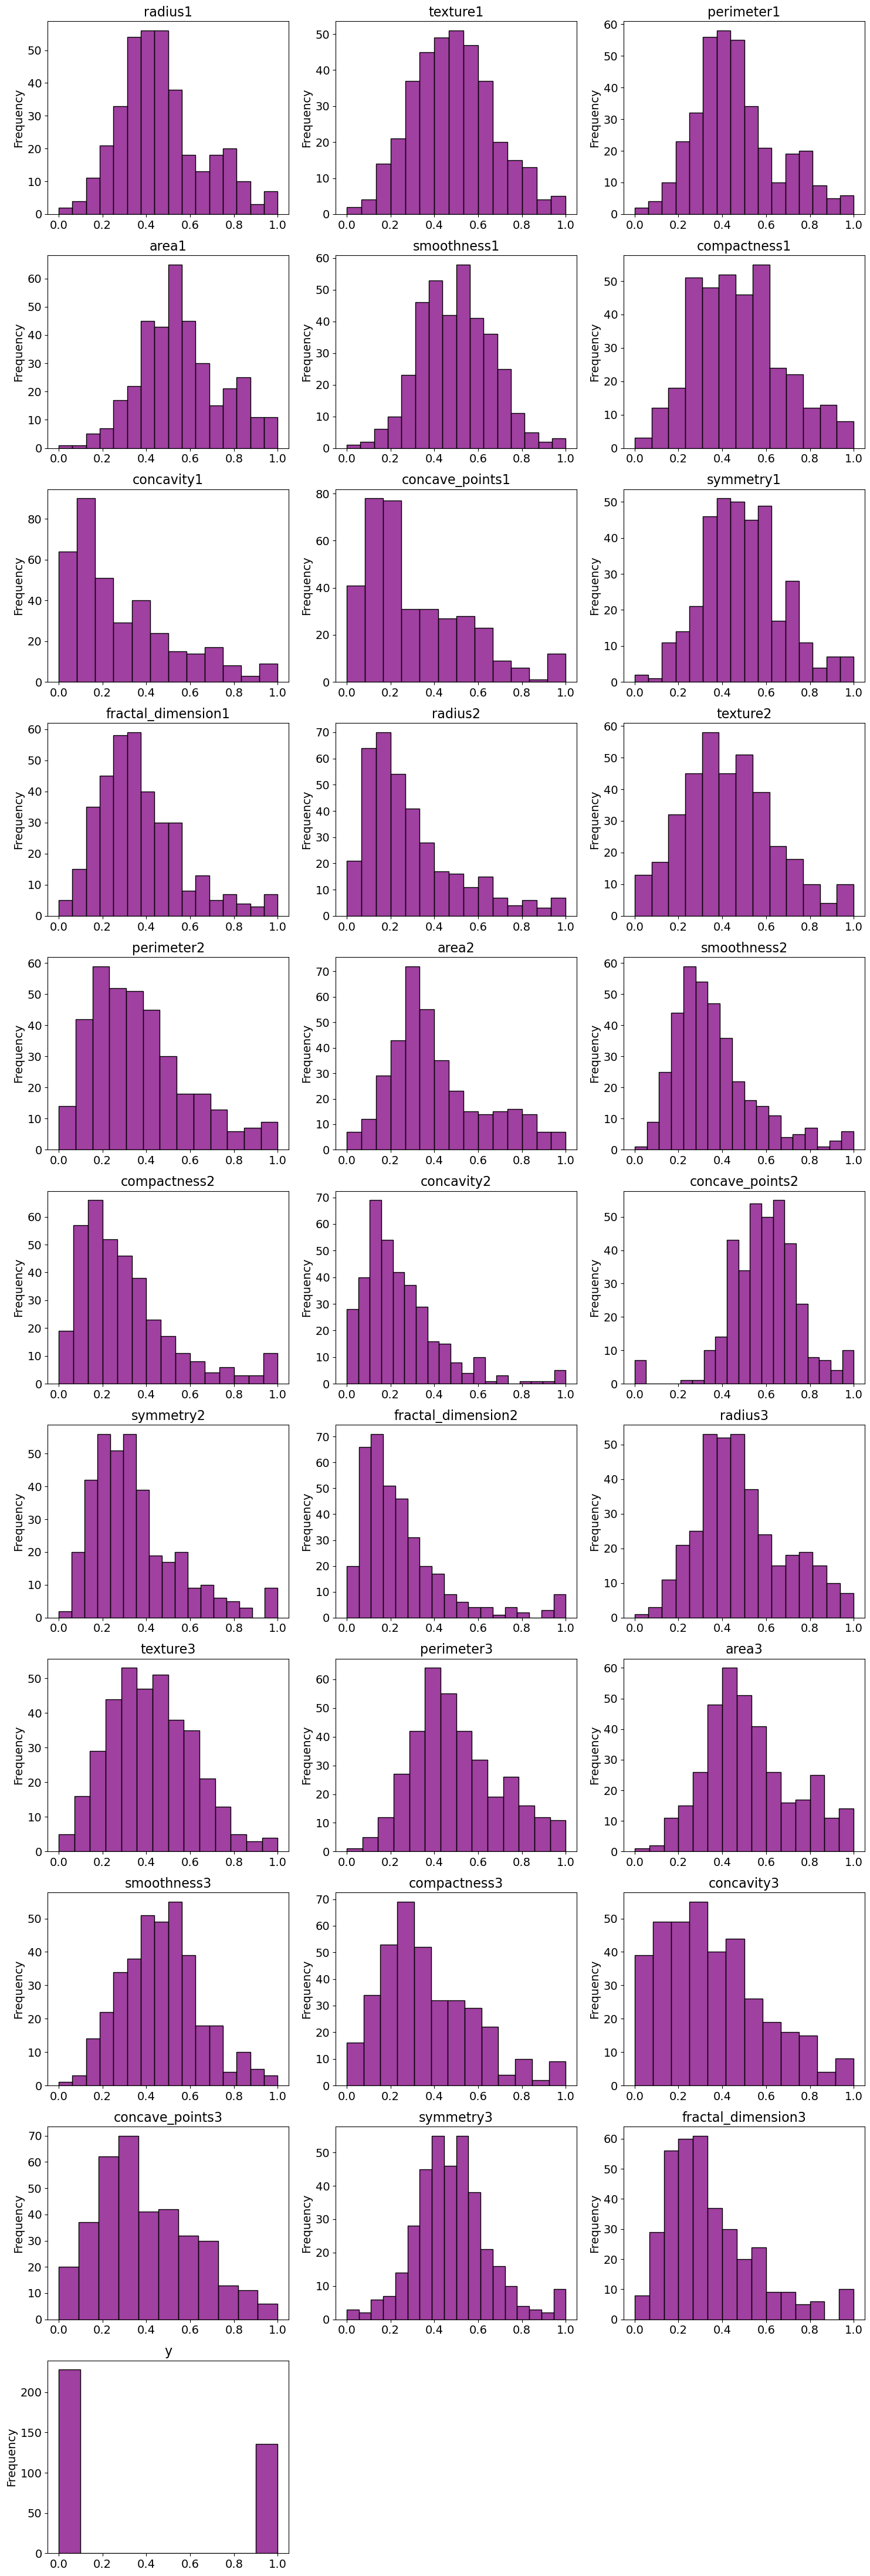

In [15]:
# Fit the scaler on the training set and apply the same transformation to validation and test sets
train_scaled, [validation_scaled, test_scaled] = scale_features(train_transformed, 
                                                                 [validation_transformed, test_transformed],
                                                                 'y',
                                                                 scaler=MinMaxScaler())

# Check the new distributions
plot_histograms(train_scaled)

## **4. Training and Evaluating Models**

In [16]:
# Prepare the modeling sets
# droping y from train set
X_train = train_scaled.drop('y', axis=1)
y_train = train_scaled['y']

X_val = validation_scaled.drop('y', axis=1)
y_val = validation_scaled['y']

X_test = test_scaled.drop('y', axis=1)
y_test = test_scaled['y']

##### **4.1 Logistic Regression Models** (For each possible number of dimensions (Using PCA))

In [17]:
model = LogisticRegression(max_iter=1000)

# Hyperparameter distributions for the model (example for logistic regression)
param_distributions = {
    'model__C': [0.1, 1, 10, 100]
}

# Run the experiment for PCA dimensions 1 through 30.
results_LR = run_dimensionality_experiment(
    X_train, y_train,  # training set
    X_val, y_val,      # validation set
    X_test, y_test,    # test set
    model,             # the model to use
    param_distributions,  # hyperparameter distributions
    dim_range=range(1, 31),
    cv=5,
    n_iter=4,
    scoring='f1'
)

# Printing best hyperparameters for 2 PCA components, which is needed for decision boundary plot later 
best_params_2 = results_LR[2]['best_params']
print(best_params_2)

PCA components: 30, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 29, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 28, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 27, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 26, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 25, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 24, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 23, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 22, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 21, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 20, Train F2: 0.9808, Val F2: 1.0000, Test F2: 0.9716
PCA components: 19, Train F2: 0.9823, Val F2: 1.0000, Test F2: 0.9716
PCA components: 18, Train F2: 0.9675, Val F2: 1.0000, Test F2: 0.9809
PCA components: 17, Train F2: 0.9808, Val F2: 1.0000, Test F2: 0.9716
PCA components: 16, 

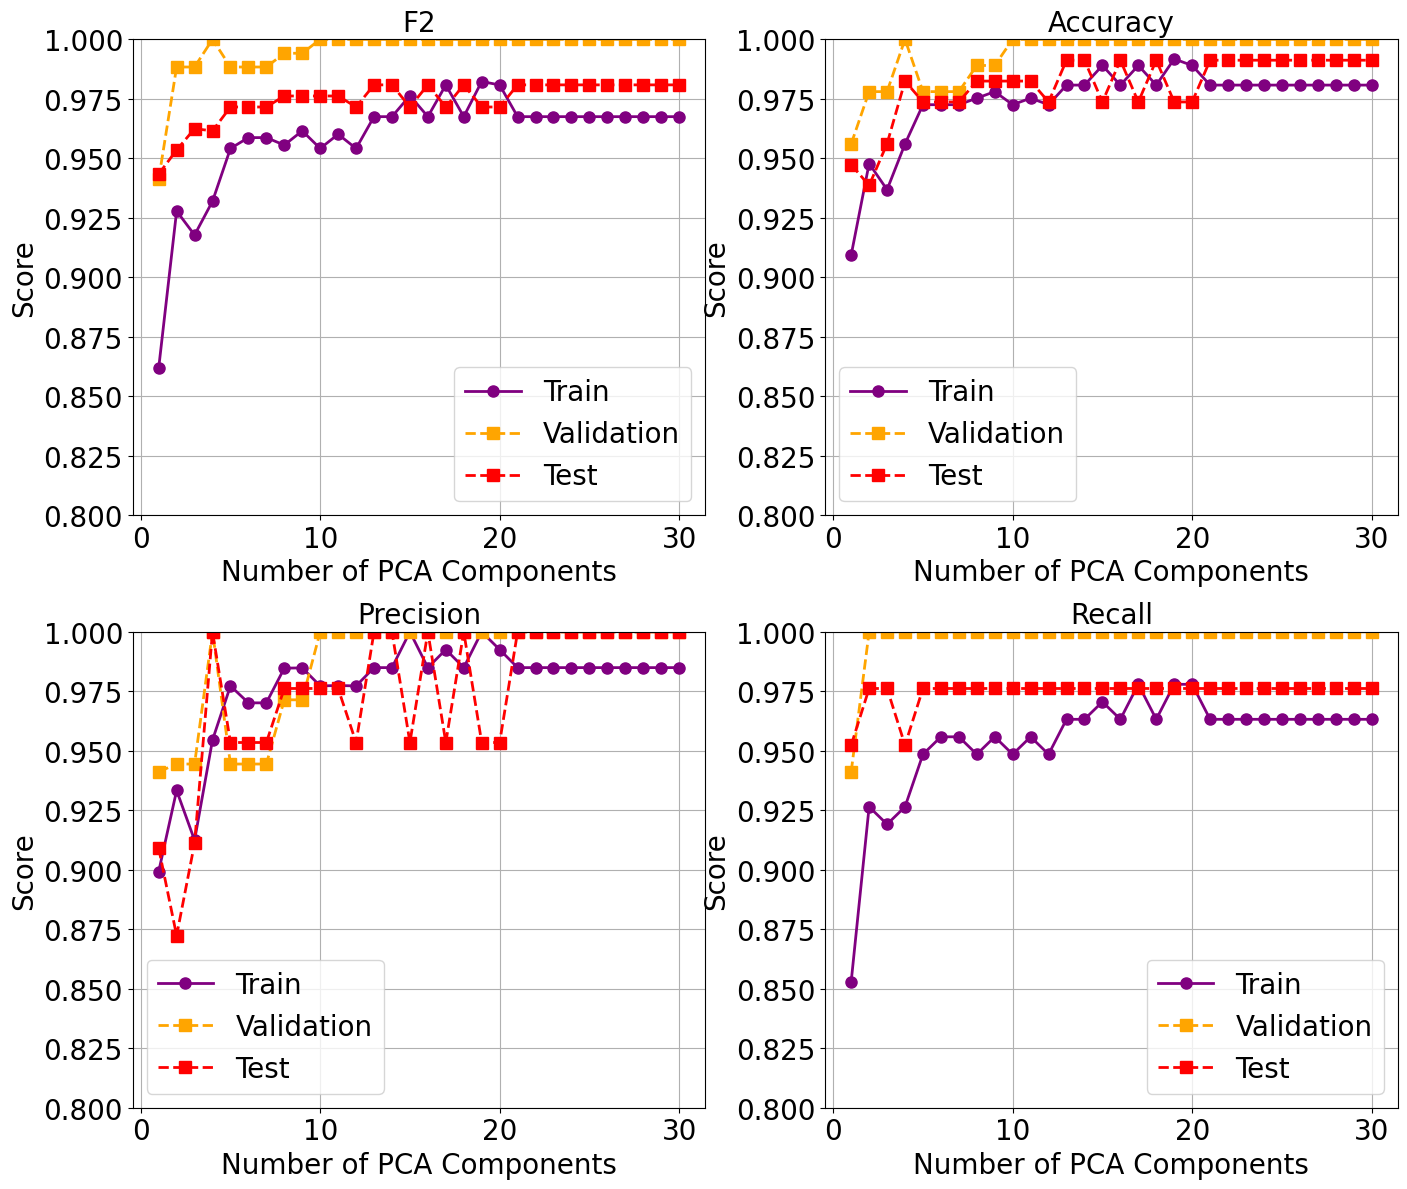

In [18]:
plot_results(results_LR, ylim=(0.8, 1))

##### **4.2 SVM-Classifiers** (For each possible number of dimensions (Using PCA))

In [19]:
from sklearn.svm import SVC

# SVC for SVM classification.
model = SVC()

# Hyperparameter distributions for SVM.
param_distributions = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

# Run the experiment for PCA dimensions 1 through 30.
results_SVM = run_dimensionality_experiment(
    X_train, y_train,  # training set
    X_val, y_val,      # validation set
    X_test, y_test,    # test set
    model,             # the model to use
    param_distributions,  # hyperparameter distributions
    dim_range=range(1, 31),
    cv=5,
    n_iter=4,
    scoring='f1'
)

# Printing best hyperparameters for 2 PCA components, which is needed for decision boundary plot later 
best_params_2 = results_SVM[2]['best_params']
print(best_params_2)

PCA components: 30, Train F2: 0.9823, Val F2: 0.9942, Test F2: 0.9479
PCA components: 29, Train F2: 0.9823, Val F2: 0.9942, Test F2: 0.9479
PCA components: 28, Train F2: 0.9823, Val F2: 0.9942, Test F2: 0.9479
PCA components: 27, Train F2: 0.9823, Val F2: 0.9942, Test F2: 0.9479
PCA components: 26, Train F2: 0.9823, Val F2: 0.9942, Test F2: 0.9479
PCA components: 25, Train F2: 0.9823, Val F2: 0.9942, Test F2: 0.9670
PCA components: 24, Train F2: 0.9823, Val F2: 0.9942, Test F2: 0.9670
PCA components: 23, Train F2: 0.9763, Val F2: 1.0000, Test F2: 0.9809
PCA components: 22, Train F2: 0.9763, Val F2: 1.0000, Test F2: 0.9809
PCA components: 21, Train F2: 0.9763, Val F2: 1.0000, Test F2: 0.9809
PCA components: 20, Train F2: 0.9763, Val F2: 1.0000, Test F2: 0.9809
PCA components: 19, Train F2: 0.9763, Val F2: 1.0000, Test F2: 0.9809
PCA components: 18, Train F2: 0.9763, Val F2: 1.0000, Test F2: 0.9809
PCA components: 17, Train F2: 0.9763, Val F2: 1.0000, Test F2: 0.9809
PCA components: 16, 

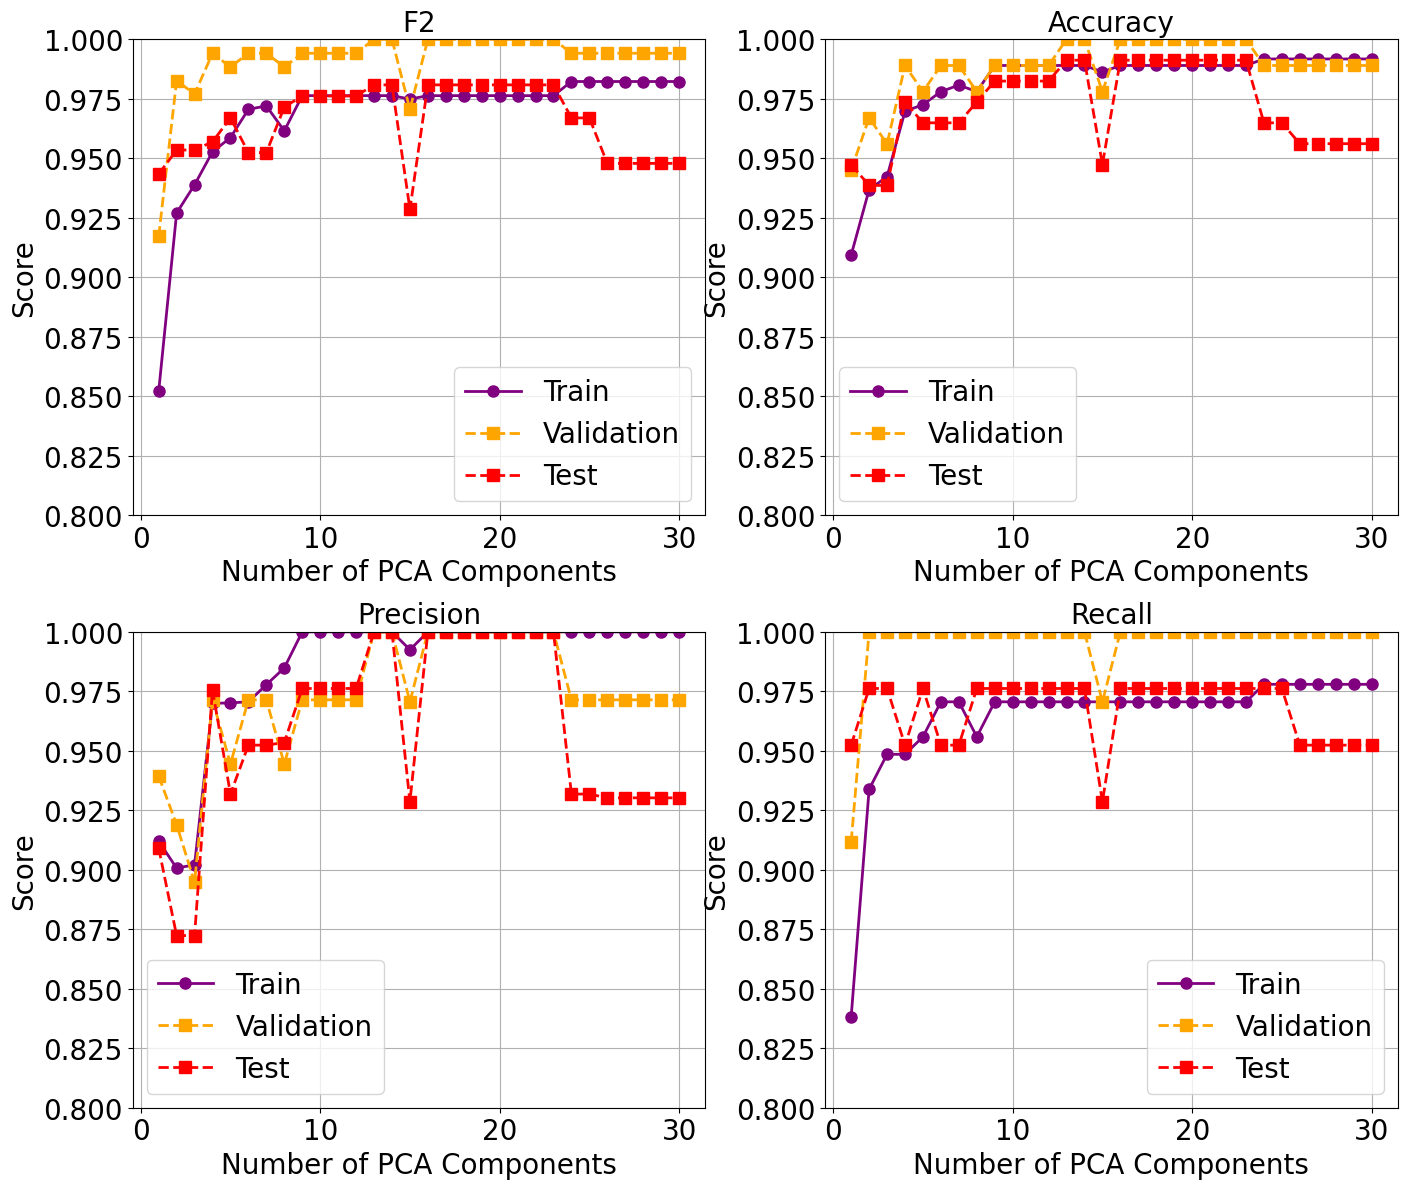

In [20]:
plot_results(results_SVM, ylim=(0.8, 1))

##### **4.3 Random Forrest Classifier** (For each possible number of dimensions (Using PCA))

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Use RandomForestClassifier for classification.
model = RandomForestClassifier(random_state=1)

# Hyperparameter distributions for the random forest.
param_distributions = {
    'model__n_estimators': [10, 25, 50, 100],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

# Run the experiment for PCA dimensions 1 through 30.
results_RF = run_dimensionality_experiment(
    X_train, y_train,  # training set
    X_val, y_val,      # validation set
    X_test, y_test,    # test set 
    model,             # the model to use
    param_distributions,  # hyperparameter distributions
    dim_range=range(1, 31),
    cv=5,
    n_iter=4,
    scoring='f1'
)

# Printing best hyperparameters for 2 PCA components, which is needed for decision boundary plot later 
best_params_2 = results_RF[2]['best_params']
print(best_params_2)

PCA components: 30, Train F2: 1.0000, Val F2: 0.9467, Test F2: 0.9579
PCA components: 29, Train F2: 1.0000, Val F2: 0.9706, Test F2: 0.9624
PCA components: 28, Train F2: 1.0000, Val F2: 0.9649, Test F2: 0.9434
PCA components: 27, Train F2: 0.9941, Val F2: 0.9412, Test F2: 0.9579
PCA components: 26, Train F2: 1.0000, Val F2: 0.9412, Test F2: 0.9434
PCA components: 25, Train F2: 1.0000, Val F2: 0.9706, Test F2: 0.9434
PCA components: 24, Train F2: 1.0000, Val F2: 0.9467, Test F2: 0.9670
PCA components: 23, Train F2: 1.0000, Val F2: 0.9412, Test F2: 0.9624
PCA components: 22, Train F2: 1.0000, Val F2: 0.9467, Test F2: 0.9670
PCA components: 21, Train F2: 1.0000, Val F2: 0.9706, Test F2: 0.9434
PCA components: 20, Train F2: 1.0000, Val F2: 0.9706, Test F2: 0.9434
PCA components: 19, Train F2: 1.0000, Val F2: 0.9706, Test F2: 0.9242
PCA components: 18, Train F2: 1.0000, Val F2: 0.9649, Test F2: 0.9624
PCA components: 17, Train F2: 1.0000, Val F2: 0.9706, Test F2: 0.9390
PCA components: 16, 

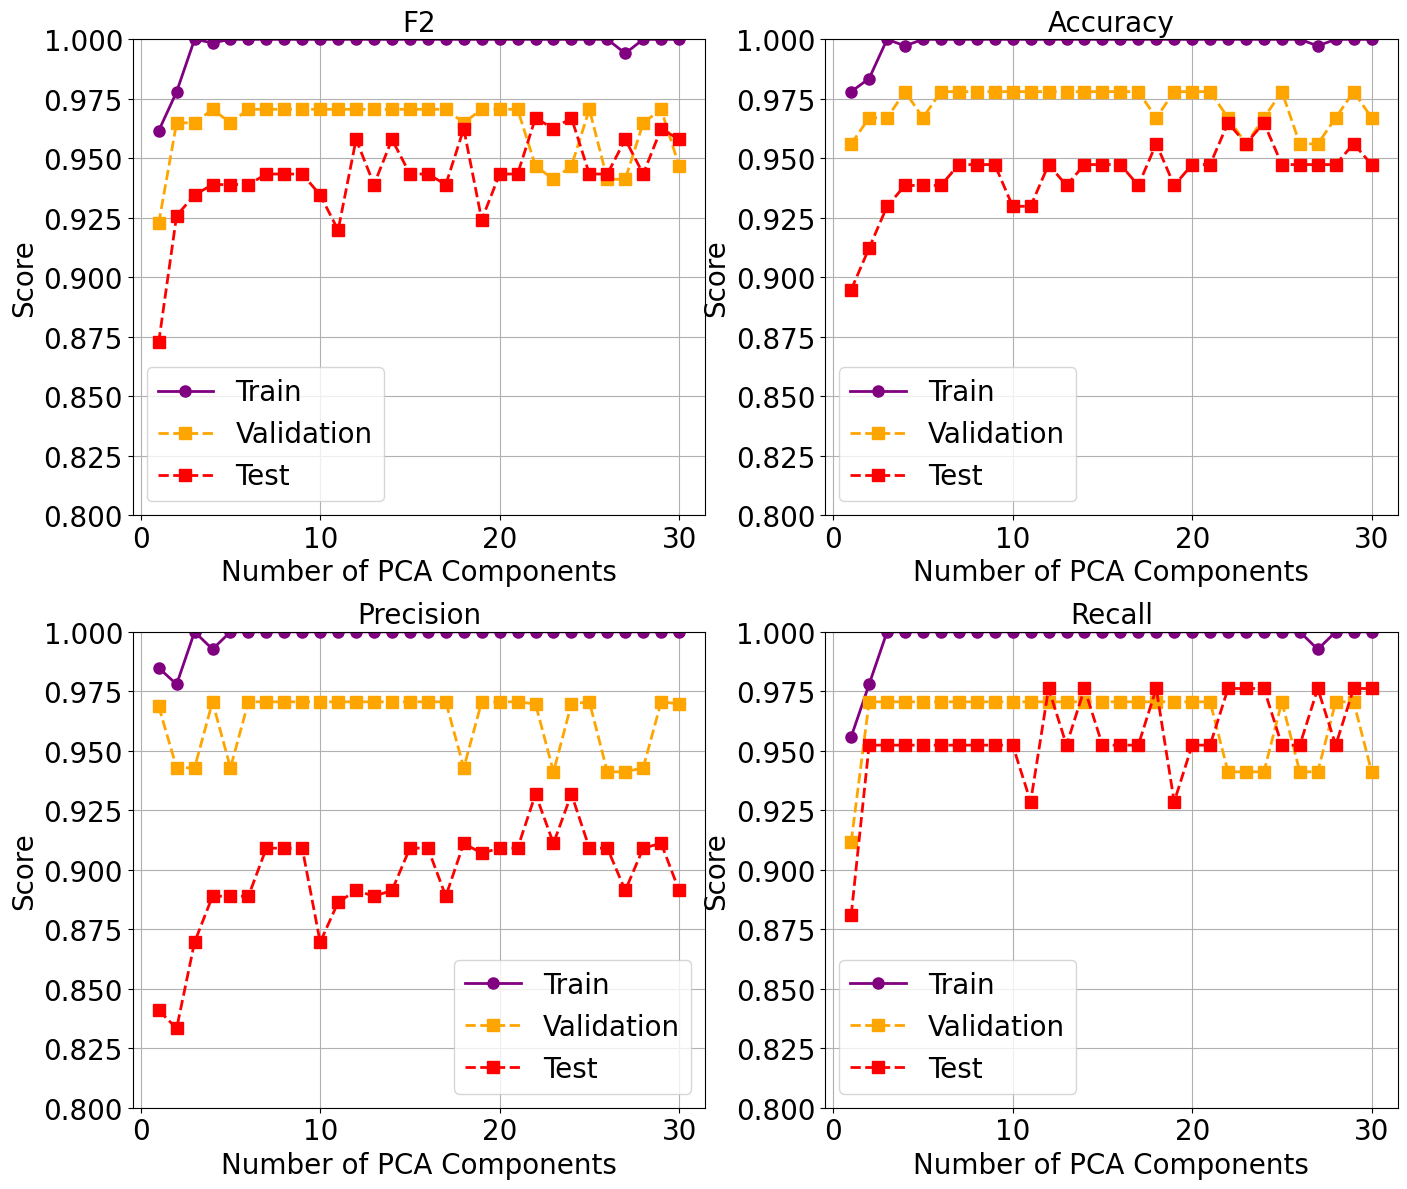

In [22]:
plot_results(results_RF, ylim=(0.8, 1))

##### **4.4 MLP Classifier** (For each possible number of dimensions (Using PCA))

In [23]:
from sklearn.neural_network import MLPClassifier

# Define the neural network model.
model = MLPClassifier(random_state=1, max_iter=3000, early_stopping=False) 

# Hyperparameter distributions for the neural network.
param_distributions = {
    'model__hidden_layer_sizes': [(5,), (10,), (20,), (10, 10)], # or 2 layer network with 10 & 10
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.001, 0.01, 0.1],
    'model__learning_rate_init': [0.001, 0.005, 0.01]
}

# Run the experiment for PCA dimensions 1 through 30.
results_MLP = run_dimensionality_experiment(
    X_train, y_train,  # training set
    X_val, y_val,      # validation set
    X_test, y_test,    # test set
    model,             # the model to use
    param_distributions,  # hyperparameter distributions
    dim_range=range(1, 31),
    cv=5,
    n_iter=4,
    scoring='f1'
)
 
# Printing best hyperparameters for 2 PCA components, which is needed for decision boundary plot later 
best_params_2 = results_MLP[2]['best_params']
print(best_params_2)

PCA components: 30, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9615
PCA components: 29, Train F2: 0.9808, Val F2: 1.0000, Test F2: 0.9762
PCA components: 28, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9569
PCA components: 27, Train F2: 0.9808, Val F2: 0.9763, Test F2: 0.9615
PCA components: 26, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9615
PCA components: 25, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9809
PCA components: 24, Train F2: 0.9749, Val F2: 0.9763, Test F2: 0.9615
PCA components: 23, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9809
PCA components: 22, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9420
PCA components: 21, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9569
PCA components: 20, Train F2: 0.9704, Val F2: 0.9763, Test F2: 0.9420
PCA components: 19, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9375
PCA components: 18, Train F2: 0.9823, Val F2: 0.9763, Test F2: 0.9420
PCA components: 17, Train F2: 0.9808, Val F2: 0.9763, Test F2: 0.9420
PCA components: 16, 

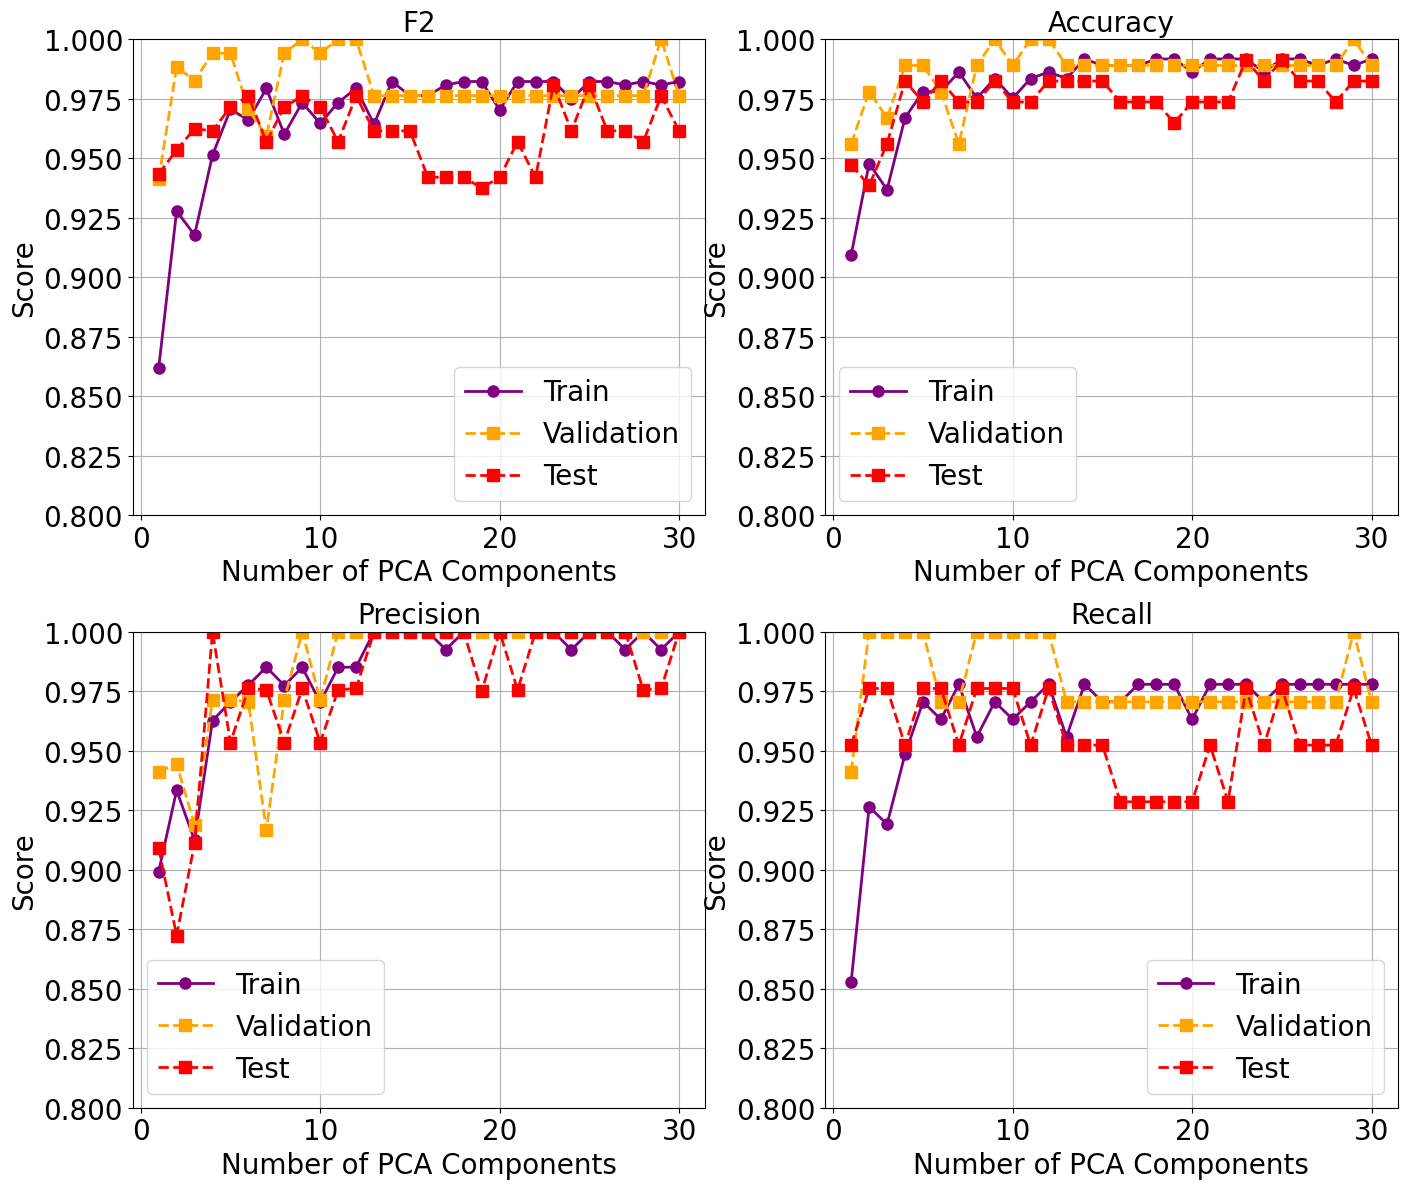

In [24]:
plot_results(results_MLP, ylim=(0.8, 1))

In [25]:
# Increase display settings
pd.set_option('display.max_rows', 120)
rank_results(results_LR, results_SVM, results_RF, results_MLP, top_n = 120)


,Rank,Model,PCA-Components,F2-Score,Recall,Accuracy,Precision
0,1,Logistic Regression,30,0.980861,0.976190,0.991228,1.000000
16,2,Logistic Regression,14,0.980861,0.976190,0.991228,1.000000
97,3,MLP,23,0.980861,0.976190,0.991228,1.000000
95,4,MLP,25,0.980861,0.976190,0.991228,1.000000
39,5,SVM,21,0.980861,0.976190,0.991228,1.000000
40,6,SVM,20,0.980861,0.976190,0.991228,1.000000
41,7,SVM,19,0.980861,0.976190,0.991228,1.000000
1,8,Logistic Regression,29,0.980861,0.976190,0.991228,1.000000
42,9,SVM,18,0.980861,0.976190,0.991228,1.000000
43,10,SVM,17,0.980861,0.976190,0.991228,1.000000


In [26]:
# ranked_results = rank_results(results_LR, results_SVM, results_RF, results_MLP, top_n = 120)
# ranked_results.to_csv("ranked_results.csv", index=False)

# **5. Exploration of PCA Components**

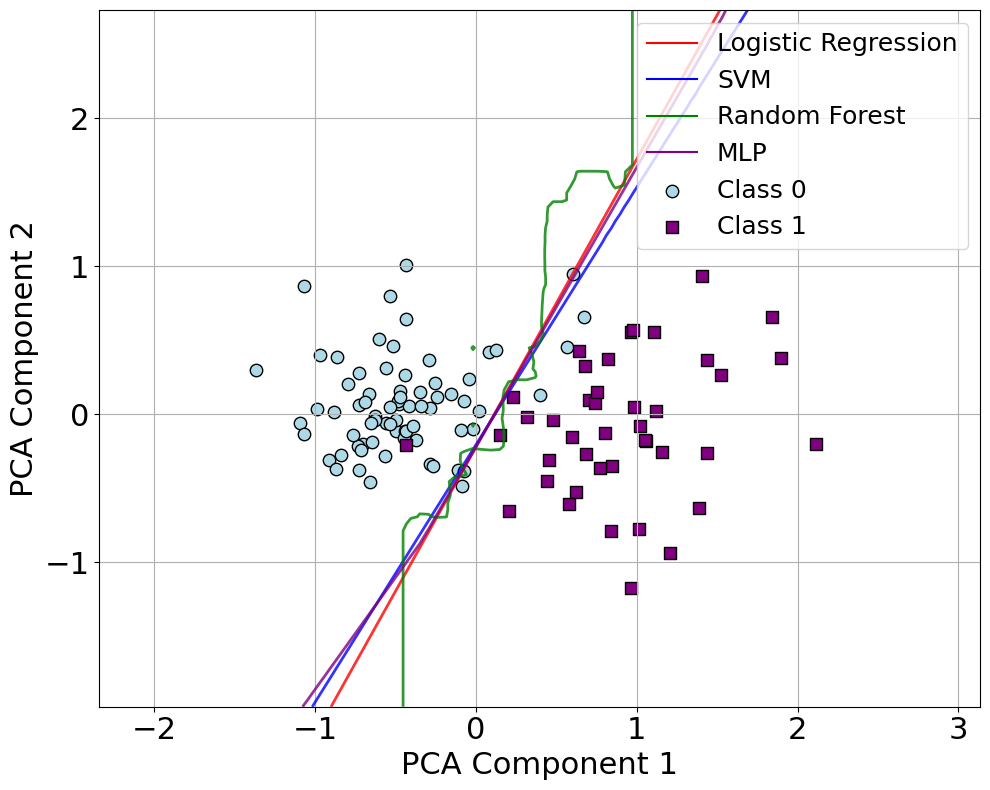

In [27]:
# Decision Boundaries on test set
decision_boundary(X_train, y_train, X_test, y_test)

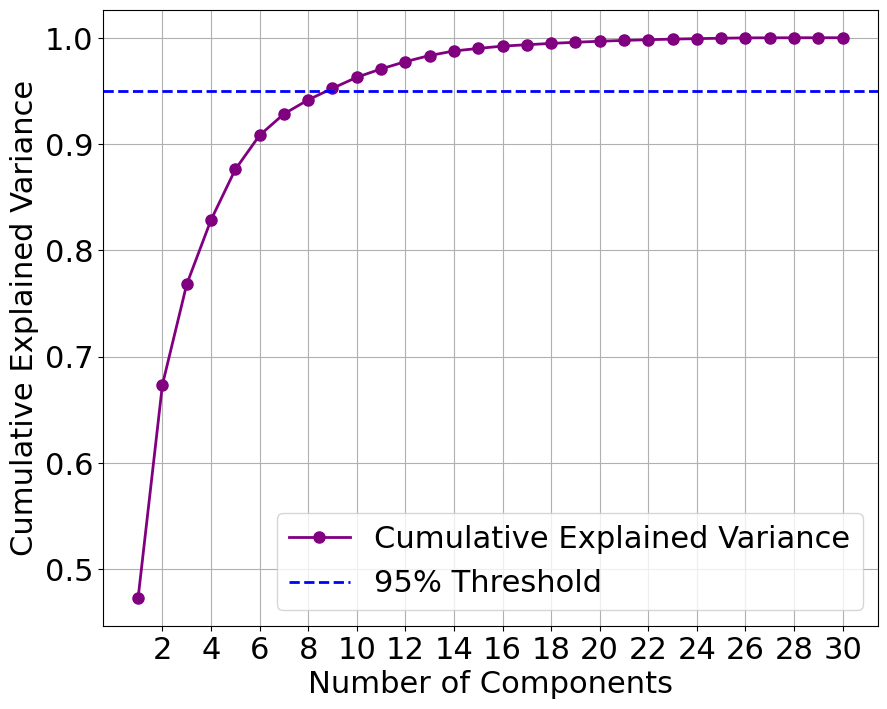

In [28]:
#Cumulative Explained Variance Curve
plot_cumulative_explained_variance(X_train)